<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Wiener-filter" data-toc-modified-id="The-Wiener-filter-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Wiener filter</a></span><ul class="toc-item"><li><span><a href="#Numerical-estimation-of-correlation-matrix-$R$-and-cross-correlation-vector-$p$" data-toc-modified-id="Numerical-estimation-of-correlation-matrix-$R$-and-cross-correlation-vector-$p$-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Numerical estimation of correlation matrix $R$ and cross-correlation vector $p$</a></span></li><li><span><a href="#Example-of-aplication:-system-identification" data-toc-modified-id="Example-of-aplication:-system-identification-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example of aplication: system identification</a></span></li><li><span><a href="#Example-of-aplication:-channel-equalization" data-toc-modified-id="Example-of-aplication:-channel-equalization-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Example of aplication: channel equalization</a></span></li></ul></li><li><span><a href="#Least-Mean-Square-(LMS)-algorithm" data-toc-modified-id="Least-Mean-Square-(LMS)-algorithm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Least-Mean-Square (LMS) algorithm</a></span><ul class="toc-item"><li><span><a href="#Example:-system-identification" data-toc-modified-id="Example:-system-identification-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example: system identification</a></span></li><li><span><a href="#Example:-channel-equalization" data-toc-modified-id="Example:-channel-equalization-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Example: channel equalization</a></span></li></ul></li></ul></div>

In [53]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b master https://github.com/edsonportosilva/adaptive-signal-processing
    from os import chdir as cd
    cd('/content/notebooks/')
    ! pip install -e .
    ! pip install SciencePlots

import sympy as sp
from sympy import latex
import numpy as np
from IPython.display import Math, Latex, display
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from IPython.core.display import HTML
from IPython.display import Image
try:
    import scienceplots
except:
    ! pip install SciencePlots
    
from utils import set_preferences, genConvGIF, symdisp, round_expr

plt.style.use(['science','ieee'])
set_preferences()

plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.dpi'] = 150

saveFigures = False
figurePath = 'G:\\Meu Drive\\DEE UFCG\\Disciplinas e ementas\\TEEE - Processamento adaptativo de sinais\\lecture notes\\figures\\'

# The Wiener filter and the LMS algorithm

## The Wiener filter

### Numerical estimation of correlation matrix $R$ and cross-correlation vector $p$

In [56]:
def estimate_correlation_matrix(x, N):
    """
    Estimate the unbiased correlation matrix R of order N from a sequence of random values x.
    
    Parameters
    ----------
    x : array-like
        The sequence of random values (x0, x1, ..., xM-1) of length M.
    N : int
        The order of the correlation matrix. Must be less than or equal to M.
    
    Returns
    -------
    R : np.ndarray
        The estimated unbiased correlation matrix of shape (N, N).
        Each element R[i, j] represents the unbiased estimate of the correlation between x[k] 
        and x[k - |i - j|] over the sequence.
    
    Raises
    ------
    ValueError
        If N is greater than the length of the sequence M.
    
    Notes
    -----
    The unbiased correlation matrix is estimated by normalizing the sum of products 
    of values from the sequence x at different lags. This compensates for the 
    decreasing number of available pairs as the lag increases.    

    """
    M = len(x)
    if N > M:
        raise ValueError("Order N should be smaller than or equal to the length of the sequence M.")
    
    # Create a matrix where each row is a shifted version of the original sequence
    X = np.array([x[i:M-N+i+1] for i in range(N)])
    
    # Compute the unbiased correlation matrix
    R = (X @ X.T) / (M - np.arange(N)[:, None])
    
    return R

def estimate_cross_correlation(x, d, N):
    """
    Estimate the unbiased cross-correlation vector p[k] between x_vec[k] = [x[k], x[k-1], ..., x[k-N+1]]
    and the sample d[k] of the sequence d.
    
    Parameters
    ----------
    x : array-like
        The sequence of random values (x0, x1, ..., xM-1) of length M.
    d : array-like
        The sequence d of length M, representing the values to correlate with x_vec.
    N : int
        The length of the vector x_vec (order of cross-correlation). Must be less than or equal to M.
    
    Returns
    -------
    p : np.ndarray
        The unbiased cross-correlation vector of length N.
        Each element represents the estimated unbiased cross-correlation between the 
        vector x_vec = [x[k], x[k-1], ..., x[k-N+1]] and d[k].
    
    Raises
    ------
    ValueError
        If the sequences `x` and `d` do not have the same length.
        If `N` is greater than the length of the sequences.
    
    Notes
    -----
    The cross-correlation is estimated by sliding a vector x_vec of length N over the sequence x 
    and computing the product of x_vec and d[k]. The result is normalized to account for the 
    decreasing number of terms that contribute to the estimate as k approaches the end of the sequence.
    
    """
    M = len(x)
    if len(d) != M:
        raise ValueError("The sequences x and d must have the same length.")
    if N > M:
        raise ValueError("N should be smaller than or equal to the length of the sequences.")

    p = np.zeros(N)
    count = np.zeros(N)  # To keep track of the number of terms contributing to each element of p
    
    # Estimate the unbiased cross-correlation
    for k in range(N, M):  # Start from k = N to ensure we can form x_vec
        x_vec = x[k:k-N:-1]  # Create the vector x_vec = [x[k], x[k-1], ..., x[k-N+1]]
        p += x_vec * d[k]
        count += 1  # Keep track of the number of terms contributing to each element
    
    # Normalize to make the estimation unbiased
    p /= count
    
    return p

### Example of aplication: system identification

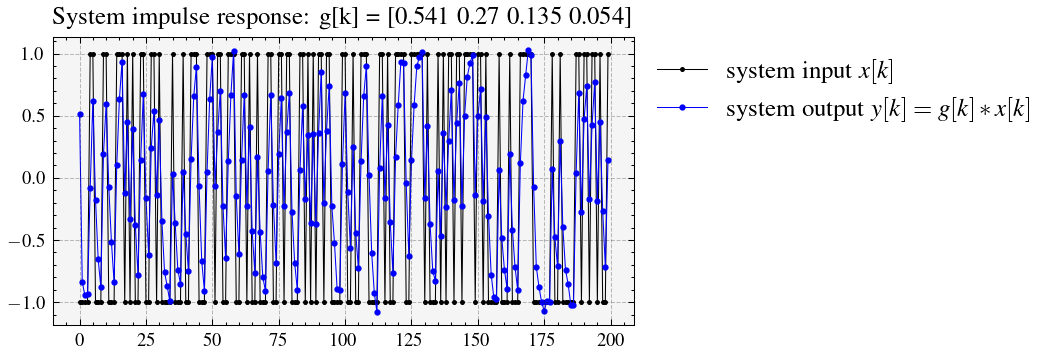

In [57]:
nsamples = 10000
σ2 = 0.0025 # noise variance

# Define input signal to the system
x = 2*np.random.randint(0, 2, nsamples)-1

# Define impulse response of the system
g = np.array([1, 0.5, 0.25, 0.1])
g = g/np.sum(g)

# Convolve input signal with system's impulse response
y = np.convolve(x, g,'same')
y = np.roll(y, 1) # remove input-output delay

# Generate noise and add noise to the systens output
n = np.random.normal(0, np.sqrt(σ2), nsamples)
y += n

plt.plot(x[0:200],'-*k', label='system input $x[k]$')
plt.plot(y[0:200],'-ob', label='system output $y[k] = g[k]\\ast x[k]$');
plt.title(f'System impulse response: g[k] = {g.round(3)}');
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

In [58]:
# Estimate correlation matrix R = E[x*x.T]
R = estimate_correlation_matrix(x, 4)

symdisp('\\boldsymbol{R}_{xx} = ', sp.Matrix(R), numDig=3)

<IPython.core.display.Math object>

In [59]:
# Estimate cross correlation matrix R = E[d*x]
p = estimate_cross_correlation(x, y, 4)

symdisp('\\boldsymbol{p}_{yx} = ', sp.Matrix(p), numDig=3)

<IPython.core.display.Math object>

In [60]:
h_opt = np.linalg.inv(R)@p
mmse_sys_id = np.mean(y**2) - (h_opt.T)@p

print('Impulse response of the system:')
symdisp('\\boldsymbol{g} = ', sp.Matrix(g), numDig=3)
print('Estimated impulse response of the system :')
symdisp('\\boldsymbol{h}_{opt} =  \\boldsymbol{R}_{xx}^{-1}\\boldsymbol{p}_{xd} =', sp.Matrix(h_opt), numDig=3)
symdisp('\\mathrm{MMSE} = \\mathbb{E}[y^2] - \\boldsymbol{h}_{opt}^{T}\\boldsymbol{p}_{yx} =', sp.Matrix([mmse_sys_id])[0], numDig=3)

Impulse response of the system:


<IPython.core.display.Math object>

Estimated impulse response of the system :


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [61]:
# Calculate estimated system output:
y_hat = np.convolve(x, h_opt, 'same')
y_hat = np.roll(y_hat, 1)

mse_estimated = np.mean((y-y_hat)**2)

print('Time averaged MSE:')
symdisp('\\mathrm{MSE} = \\frac{1}{M}\\sum_{i=1}^{M} (y[i]-\\hat{y}[i])^2 =',sp.Matrix([mse_estimated])[0], numDig=3)

Time averaged MSE:


<IPython.core.display.Math object>

### Example of aplication: channel equalization

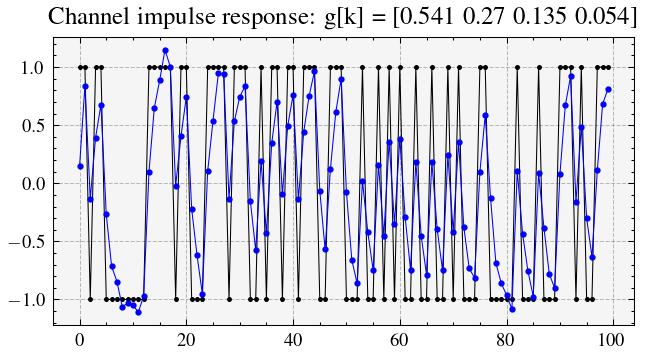

In [62]:
nsamples = 100000
σ2 = 0.0025 # noise variance

# Define input signal to the system
x = 2*np.random.randint(0, 2, nsamples)-1

# Define impulse response of the system
g = np.array([1, 0.5, 0.25, 0.1])
g = g/np.sum(g)

# Convolve input signal with system's impulse response
y = np.convolve(x, g,'same')
y = np.roll(y, 1) # remove input-output delay

# Generate noise and add noise to the systens output
n = np.random.normal(0, np.sqrt(σ2), nsamples)
y += n

plt.plot(x[0:100],'-*k', label='system input')
plt.plot(y[0:100],'-ob', label='system output');
plt.title(f'Channel impulse response: g[k] = {g.round(3)}');

plt.grid()

In [63]:
# Estimate correlation matrix R = E[y*y.T]
R = estimate_correlation_matrix(y, 4)

symdisp('\\boldsymbol{R}_{yy} = ', sp.Matrix(R), numDig=3)

<IPython.core.display.Math object>

In [64]:
# Estimate cross correlation matrix R = E[x*y]
p = estimate_cross_correlation(y, x, 4)

symdisp('\\boldsymbol{p}_{xy} = ', sp.Matrix(p), numDig=3)

<IPython.core.display.Math object>

In [65]:
h_opt = np.linalg.inv(R)@p
mmse_ch_eq = np.mean(x**2) - (h_opt.T)@p

print('Impulse response of the system:')
symdisp('\\boldsymbol{g} = ', sp.Matrix(g), numDig=3)
print('Estimated equalizer filter coefficients:')
symdisp('\\boldsymbol{h}_{opt} =  \\boldsymbol{R}_{yy}^{-1}\\boldsymbol{p}_{yx} =', sp.Matrix(h_opt), numDig=3)
symdisp('\\mathrm{MMSE} = \\mathbb{E}[x^2] - \\boldsymbol{h}_{opt}^{T}\\boldsymbol{p}_{xy} =', sp.Matrix([mmse_ch_eq])[0], numDig=3)

Impulse response of the system:


<IPython.core.display.Math object>

Estimated equalizer filter coefficients:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time averaged MSE:


<IPython.core.display.Math object>

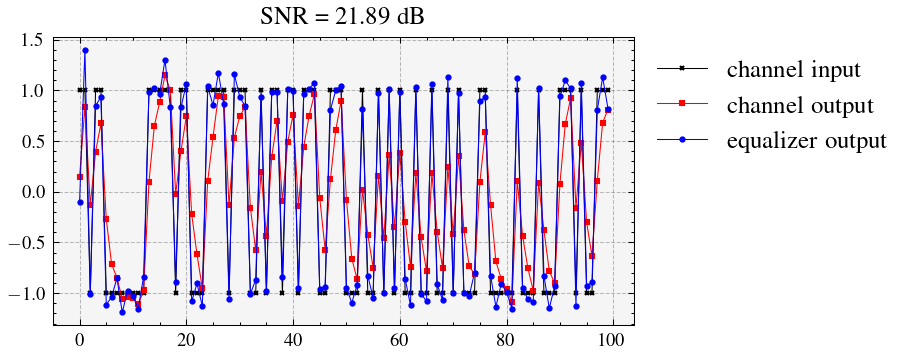

In [66]:
# Convolve input signal with equalizer impulse response
x_hat = np.convolve(y, h_opt, 'same')
x_hat = np.roll(x_hat, 1) # remove input-output delay

mse_estimated = np.mean((x-x_hat)**2)
print('Time averaged MSE:')
symdisp('\\mathrm{MSE} = \\frac{1}{M}\\sum_{i=1}^{M} (x[i]-\\hat{x}[i])^2 =',sp.Matrix([mse_estimated])[0], numDig=3)
        
plt.plot(x[0:100],'-xk', label='channel input')
plt.plot(y[0:100],'-sr', label='channel output')
plt.plot(x_hat[0:100],'-ob', label='equalizer output');
plt.title(f' SNR = {10*np.log10(np.mean((y-n)**2)/np.mean(n**2)):.2f} dB')
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

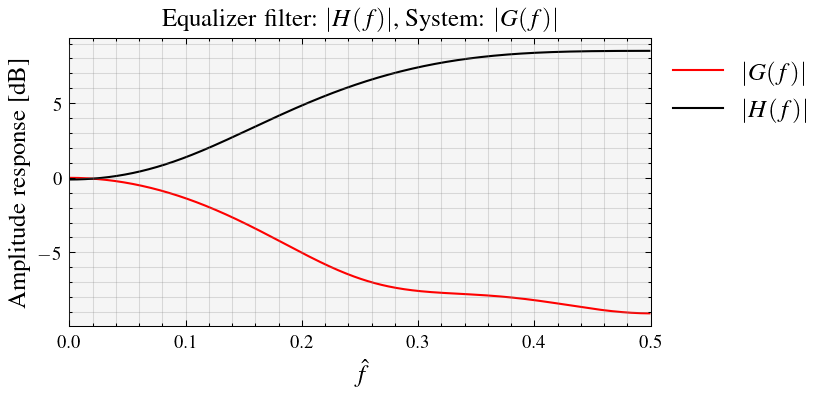

In [67]:
from scipy.signal import freqz

fs = 1

plt.figure()

ω, g_freq = freqz(b=g, a=1)
freqs = ω * fs * 1.0 / (2 * np.pi)
Gfreq = 20*np.log10(np.abs(g_freq))
plt.plot(freqs, Gfreq, '-r', label = '$|G(f)|$', linewidth=1)
plt.xlim(0,0.5);


ω, h_freq = freqz(b=h_opt, a=1)
freqs = ω * fs * 1.0 / (2 * np.pi)
Hfreq = 20*np.log10(np.abs(h_freq))
plt.plot(freqs, Hfreq,label = f'$|H(f)|$', linewidth=1)
    
plt.ylabel('Amplitude response [dB]')
plt.xlabel('$\\hat{f}$')
plt.title('Equalizer filter: $|H(f)|$, System: $|G(f)|$')
plt.grid(which='both', linestyle='-', color='grey')
plt.legend(bbox_to_anchor=(1, 1));

## Least-Mean-Square (LMS) algorithm

In [68]:
from numba import njit

@njit
def lms(x, d, Ntaps, μ):
    """
    The Least Mean Squares (LMS) algorithm.

    Parameters:
        x (ndarray): The input signal.
        d (ndarray): The reference signal.
        Ntaps (int): The number of filter taps.
        μ (float): The LMS step size.

    Returns:
        tuple: A tuple containing:
            - ndarray: The output signal.
            - ndarray: The final filter coefficients.
            - ndarray: The squared error at each iteration.

    """
    # Initialize the equalizer filter coefficients
    h = np.zeros(Ntaps)          
    ind = np.arange(0,Ntaps)
   
    # Apply the LMS algorithm
    squaredError = np.zeros(x.shape)
    out  = np.zeros(x.shape)
        
    # Iterate through each sample of the signal
    for i in range(Ntaps, len(x)):
        x_vec = x[i-ind]

        # Generate the estimated signal using the equalizer filter
        y = np.sum(x_vec * h)

        # Compute the error between the estimated signal and the reference signal
        error = d[i] - y

        # Update the filter coefficients using the LMS update rule
        h += μ * error * x_vec 

        squaredError[i] = error**2
        out[i] = y

    return out, h, squaredError

### Example: system identification

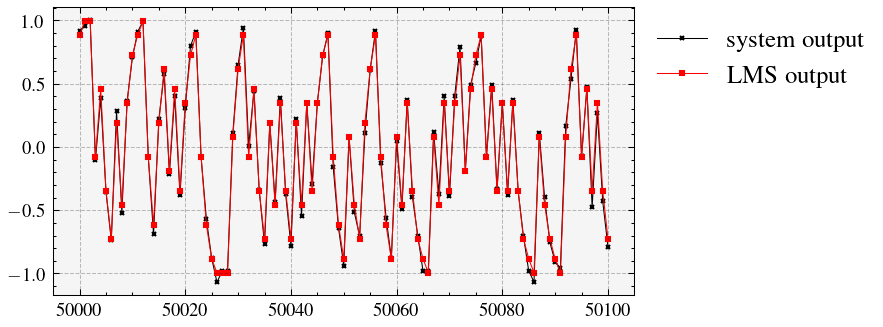

In [69]:
μ = 1e-4
Ntaps = 4

out, h, squaredError = lms(x, y, Ntaps, μ)

start = 50000
ind = np.arange(start,start+101)

plt.plot(ind,y[ind],'-xk', label='system output')
plt.plot(ind,out[ind],'-sr', label='LMS output')
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

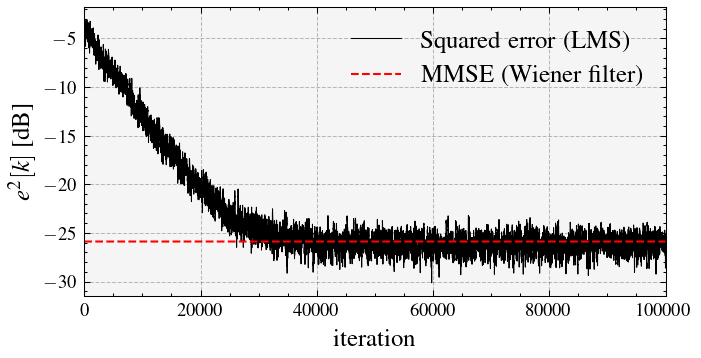

In [70]:
average_window_len = 50
error_dB = 10*np.log10(np.convolve(squaredError,np.ones(average_window_len)/average_window_len, 'same'))

plt.plot(error_dB, label='Squared error (LMS)')
plt.plot(10*np.log10(mmse_sys_id)*np.ones(len(error_dB)), linewidth=1, label='MMSE (Wiener filter)')
plt.xlim(0,len(error_dB))
plt.xlabel('iteration')
plt.ylabel('$e^2[k]$ [dB]')
plt.legend()
plt.grid();

In [71]:
symdisp('\\boldsymbol{h}_{\mathrm{LMS}} = ', sp.Matrix(h), numDig=3)

<IPython.core.display.Math object>

In [72]:
symdisp('\\boldsymbol{g} = ', sp.Matrix(g), numDig=3)

<IPython.core.display.Math object>

### Example: channel equalization

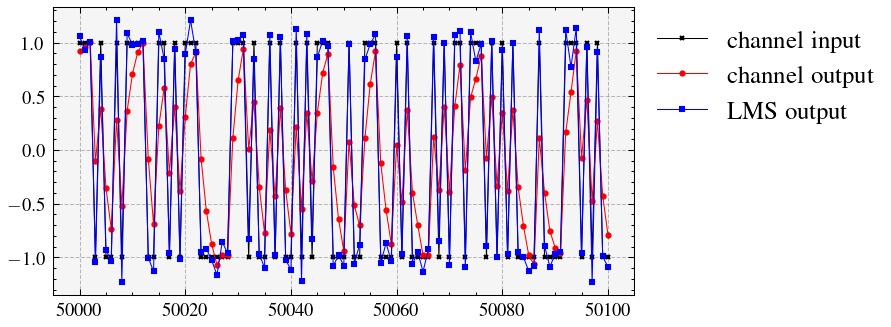

In [73]:
μ = 1e-3
Ntaps = 4

out, h, squaredError = lms(y, x, Ntaps, μ)

start = 50000
ind = np.arange(start,start+101)

plt.plot(ind,x[ind],'-xk', label='channel input')
plt.plot(ind,y[ind],'-or', label='channel output')
plt.plot(ind,out[ind],'-sb', label='LMS output')
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

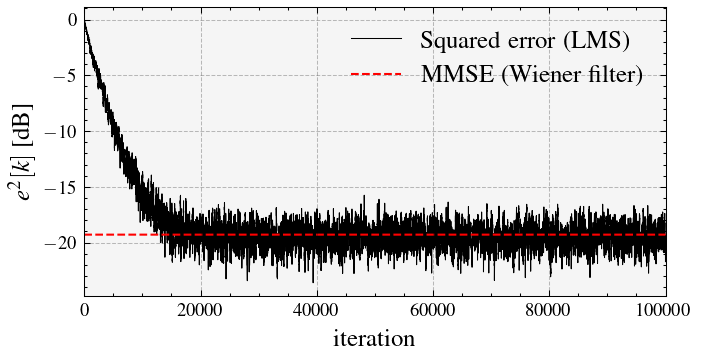

In [74]:
average_window_len = 50
error_dB = 10*np.log10(np.convolve(squaredError,np.ones(average_window_len)/average_window_len, 'same'))

plt.plot(error_dB, label='Squared error (LMS)')
plt.plot(10*np.log10(mmse_ch_eq)*np.ones(len(error_dB)), linewidth=1, label='MMSE (Wiener filter)')
plt.xlim(0,len(error_dB))
plt.xlabel('iteration')
plt.ylabel('$e^2[k]$ [dB]')
plt.legend()
plt.grid();

In [75]:
symdisp('\\boldsymbol{h}_{\mathrm{LMS}} = ', sp.Matrix(h), numDig=3)

<IPython.core.display.Math object>

In [76]:
symdisp('\\boldsymbol{h}_{opt} = ', sp.Matrix(h_opt), numDig=3)

<IPython.core.display.Math object>

### Convergence behavior for different values of step-size

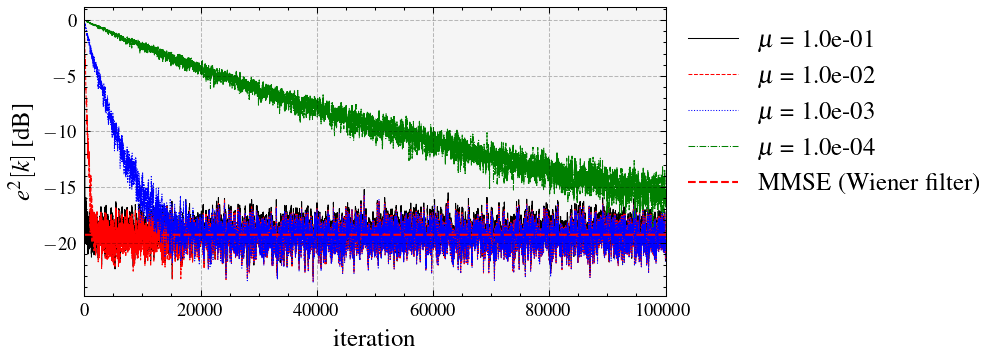

In [85]:
Ntaps = 4
average_window_len = 50

for μ in [1e-1, 1e-2, 1e-3, 1e-4]:
    out, h, squaredError = lms(y, x, Ntaps, μ)

    error_dB = 10*np.log10(np.convolve(squaredError,np.ones(average_window_len)/average_window_len, 'same'))
    plt.plot(error_dB, label= f'$\\mu$ = {μ:.1e}')
    
plt.plot(10*np.log10(mmse_ch_eq)*np.ones(len(error_dB)),'--r', linewidth=1, label='MMSE (Wiener filter)')
plt.xlim(0,len(error_dB))
plt.xlabel('iteration')
plt.ylabel('$e^2[k]$ [dB]')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
plt.grid();